# 01_data_build_colored
- Author: 정재훈
- Date: 2025-11-10
- Goal: Colored MNIST 생성(색/배경 옵션)
- Input: 
- Output: 
- Metrics: acc@val, loss@train
- Repro: seed=42, device=auto, config=../configs/


In [1]:
# ============================================================
# 01_preprocessing_colored_mnist.ipynb
#
# Colored MNIST Preprocessing for Classical ML
# - Base MNIST + Optional Font-based digits
# - 7-color ROYGBIV foreground/background
# - Train/Val/Test split (8:1:1)
# - Raw & Scaled features
# - Font usage tracked by y_source (0=base, 1=font)
# - Rich EDA included
# ============================================================

In [2]:
# ------------------------------------------------------------
# [Cell 1] Imports & Global Config
# ------------------------------------------------------------
import os  # path handling
import random  # RNG seeding
import numpy as np  # numeric operations
import matplotlib.pyplot as plt  # visualization
import seaborn as sns  # visualization styling

from sklearn.model_selection import train_test_split  # data split
from sklearn.preprocessing import StandardScaler  # feature scaling

from PIL import Image, ImageDraw, ImageFont  # font rendering

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Visualization (English only → avoid font issues)
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False
sns.set(style="whitegrid")

print("[OK] Imports & global config ready.")

[OK] Imports & global config ready.


In [3]:
# ------------------------------------------------------------
# [Cell 2] Path Setup
#   - Works from repo root or from notebooks/ directory
# ------------------------------------------------------------
cwd = os.getcwd()  # current working directory

if os.path.basename(cwd) == "notebooks":
    BASE_DIR = os.path.dirname(cwd)  # if in notebooks/, go one level up
else:
    BASE_DIR = cwd  # otherwise assume current is repo root

RAW_DIR = os.path.join(BASE_DIR, "data", "raw")  # raw data root
MNIST_PATH = os.path.join(RAW_DIR, "mnist", "mnist_train.npz")  # MNIST npz path
OUT_DIR = os.path.join(BASE_DIR, "data", "processed", "colored_mnist")  # output dir

os.makedirs(OUT_DIR, exist_ok=True)  # create output dir if not exists

print(f"[INFO] BASE_DIR    : {BASE_DIR}")
print(f"[INFO] MNIST_PATH : {MNIST_PATH}")
print(f"[INFO] OUT_DIR    : {OUT_DIR}")

[INFO] BASE_DIR    : c:\src\colored-mnist-classification
[INFO] MNIST_PATH : c:\src\colored-mnist-classification\data\raw\mnist\mnist_train.npz
[INFO] OUT_DIR    : c:\src\colored-mnist-classification\data\processed\colored_mnist


In [4]:
# ------------------------------------------------------------
# [Cell 3] Load MNIST
#   - Expect keys: 'train_images', 'train_labels'
# ------------------------------------------------------------
if not os.path.exists(MNIST_PATH):
    raise FileNotFoundError(
        f"[ERROR] {MNIST_PATH} not found. "
        f"Place mnist_train.npz under data/raw/mnist/."
    )

mnist = np.load(MNIST_PATH)
print("[INFO] mnist_train.npz keys:", list(mnist.keys()))

if "train_images" not in mnist or "train_labels" not in mnist:
    raise KeyError("[ERROR] 'train_images' or 'train_labels' missing in mnist_train.npz")

X_gray = mnist["train_images"].astype(np.float32) / 255.0  # (N,28,28) normalized to [0,1]
y_digit = mnist["train_labels"].astype(np.int64)           # (N,)

N_base = X_gray.shape[0]
print(f"[OK] Loaded MNIST: images={X_gray.shape}, labels={y_digit.shape}")

[INFO] mnist_train.npz keys: ['train_images', 'train_labels']
[OK] Loaded MNIST: images=(60000, 28, 28), labels=(60000,)


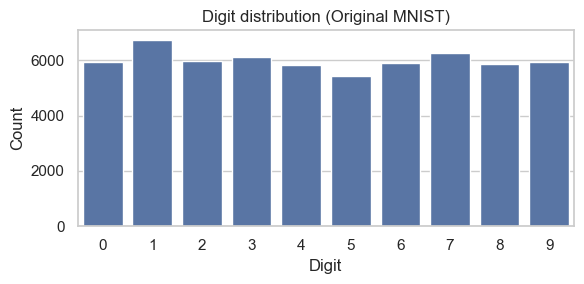

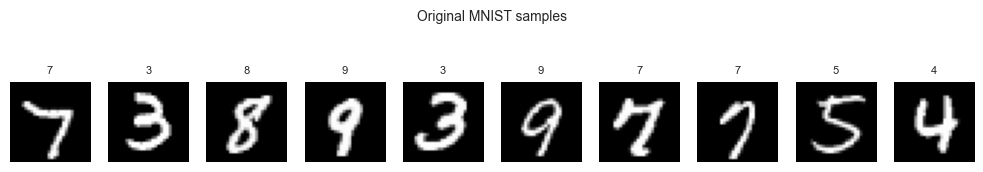

In [5]:
# ------------------------------------------------------------
# [Cell 4] EDA-1: Original MNIST Distribution & Samples
# ------------------------------------------------------------
plt.figure(figsize=(6, 3))
sns.countplot(x=y_digit)
plt.title("Digit distribution (Original MNIST)")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

def show_gray_samples(X, y, n=10, title="Original MNIST samples"):
    """Show random grayscale MNIST samples."""
    n = min(n, len(X))
    idxs = np.random.choice(len(X), n, replace=False)
    plt.figure(figsize=(n, 2))
    for i, idx in enumerate(idxs):
        plt.subplot(1, n, i + 1)
        plt.imshow(X[idx], cmap="gray")
        plt.axis("off")
        plt.title(int(y[idx]), fontsize=8)
    plt.suptitle(title, fontsize=10)
    plt.tight_layout()
    plt.show()

show_gray_samples(X_gray, y_digit)

In [6]:
# ------------------------------------------------------------
# [Cell 5] Define 7-Color Palette (ROYGBIV)
# ------------------------------------------------------------
COLOR_NAMES = ["RED", "ORANGE", "YELLOW", "GREEN", "BLUE", "INDIGO", "VIOLET"]

COLOR_RGB = {
    "RED":    (255, 0, 0),
    "ORANGE": (255, 128, 0),
    "YELLOW": (255, 255, 0),
    "GREEN":  (0, 255, 0),
    "BLUE":   (0, 0, 255),
    "INDIGO": (75, 0, 130),
    "VIOLET": (238, 130, 238),
}

NAME2IDX = {name: i for i, name in enumerate(COLOR_NAMES)}  # color name → class index
IDX2NAME = {i: name for name, i in NAME2IDX.items()}        # class index → color name

print("[OK] Color palette:")
for i, name in IDX2NAME.items():
    print(f"  {i}: {name} -> {COLOR_RGB[name]}")

[OK] Color palette:
  0: RED -> (255, 0, 0)
  1: ORANGE -> (255, 128, 0)
  2: YELLOW -> (255, 255, 0)
  3: GREEN -> (0, 255, 0)
  4: BLUE -> (0, 0, 255)
  5: INDIGO -> (75, 0, 130)
  6: VIOLET -> (238, 130, 238)


In [7]:
# ------------------------------------------------------------
# [Cell 6] Utility: Colorize & Sample Color Indices
# ------------------------------------------------------------
def colorize(gray_img, fg_rgb, bg_rgb):
    """
    Convert grayscale image (28x28, [0,1]) into RGB using:
      out = gray * fg + (1 - gray) * bg
    """
    h, w = gray_img.shape
    g = gray_img.reshape(h, w, 1)
    fg = np.array(fg_rgb, dtype=np.float32).reshape(1, 1, 3) / 255.0
    bg = np.array(bg_rgb, dtype=np.float32).reshape(1, 1, 3) / 255.0
    out = g * fg + (1.0 - g) * bg
    return np.clip(out, 0.0, 1.0)

def sample_color_indices(n, allow_same=False):
    """
    Sample (fg_idx, bg_idx) for n samples.
    If allow_same=False, enforce fg != bg.
    """
    fg = np.random.randint(0, len(COLOR_NAMES), size=n)
    bg = np.random.randint(0, len(COLOR_NAMES), size=n)
    if not allow_same:
        mask = fg == bg
        while mask.any():
            bg[mask] = np.random.randint(0, len(COLOR_NAMES), size=mask.sum())
            mask = fg == bg
    return fg, bg

In [8]:
# ------------------------------------------------------------
# [Cell 7] Build Base Colored MNIST
# ------------------------------------------------------------
def build_base_colored_mnist(X_gray, y_digit, seed=SEED):
    """Create Colored MNIST from original MNIST using random FG/BG colors."""
    np.random.seed(seed)
    N = X_gray.shape[0]
    fg_idx, bg_idx = sample_color_indices(N, allow_same=False)

    X_color = np.zeros((N, 28, 28, 3), dtype=np.float32)
    for i in range(N):
        fg_name = IDX2NAME[int(fg_idx[i])]
        bg_name = IDX2NAME[int(bg_idx[i])]
        X_color[i] = colorize(X_gray[i], COLOR_RGB[fg_name], COLOR_RGB[bg_name])

    return X_color, y_digit.copy(), fg_idx.astype(np.int64), bg_idx.astype(np.int64)

X_base, y_base_digit, y_base_fg, y_base_bg = build_base_colored_mnist(X_gray, y_digit)
print("[OK] Base Colored MNIST:", X_base.shape)

[OK] Base Colored MNIST: (60000, 28, 28, 3)


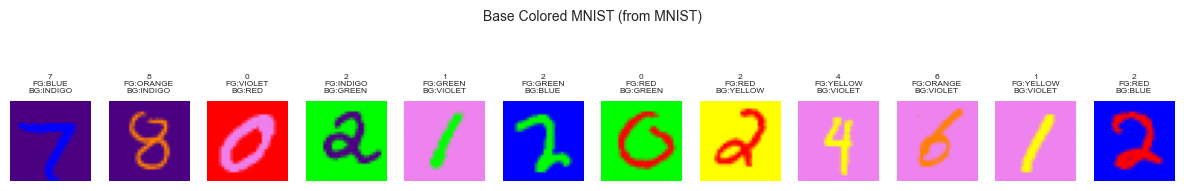

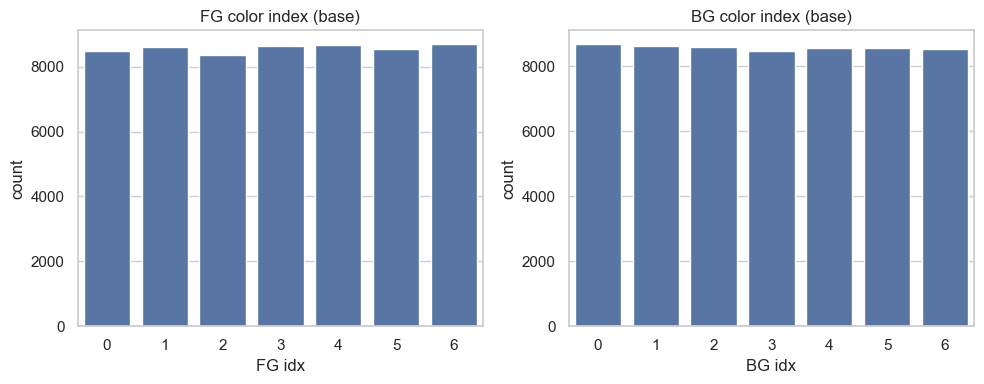

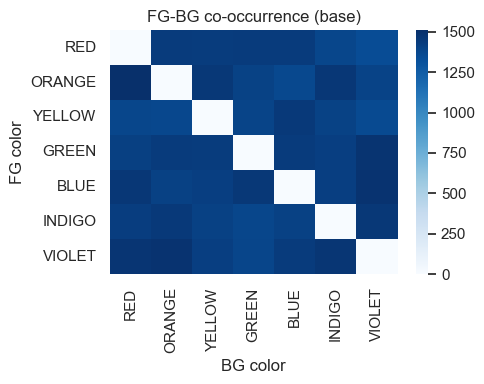

In [9]:
# ------------------------------------------------------------
# [Cell 8] EDA-2: Base Colored MNIST Visualization & Distributions
# ------------------------------------------------------------
def show_colored_samples(X, y_digit, y_fg, y_bg, n=12, title="Colored MNIST samples"):
    """Visualize random colored samples with digit/FG/BG labels."""
    n = min(n, len(X))
    idxs = np.random.choice(len(X), n, replace=False)
    plt.figure(figsize=(n, 2.4))
    for i, idx in enumerate(idxs):
        img = X[idx]
        d = int(y_digit[idx])
        fg = IDX2NAME[int(y_fg[idx])]
        bg = IDX2NAME[int(y_bg[idx])]
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{d}\nFG:{fg}\nBG:{bg}", fontsize=6)
    plt.suptitle(title, fontsize=10)
    plt.tight_layout()
    plt.show()

show_colored_samples(
    X_base, y_base_digit, y_base_fg, y_base_bg,
    title="Base Colored MNIST (from MNIST)"
)

# FG / BG distribution
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(x=y_base_fg, ax=axes[0])
axes[0].set_title("FG color index (base)")
axes[0].set_xlabel("FG idx")
sns.countplot(x=y_base_bg, ax=axes[1])
axes[1].set_title("BG color index (base)")
axes[1].set_xlabel("BG idx")
plt.tight_layout()
plt.show()

# FG-BG co-occurrence heatmap
co_mat = np.zeros((len(COLOR_NAMES), len(COLOR_NAMES)), dtype=int)
for f, b in zip(y_base_fg, y_base_bg):
    co_mat[f, b] += 1

plt.figure(figsize=(5, 4))
sns.heatmap(co_mat,
            cmap="Blues",
            xticklabels=COLOR_NAMES,
            yticklabels=COLOR_NAMES)
plt.title("FG-BG co-occurrence (base)")
plt.xlabel("BG color")
plt.ylabel("FG color")
plt.tight_layout()
plt.show()

In [10]:
# ------------------------------------------------------------
# [Cell 9] Font Path Search (Robust)
#   - Search .ttf/.otf recursively in typical locations
# ------------------------------------------------------------
def find_font_paths(base_dir):
    """
    Search for TTF/OTF fonts in:
      - data/raw/fonts
      - data/fonts
      - fonts
    (Optionally can be extended if needed)
    """
    candidates = [
        os.path.join(base_dir, "data", "raw", "fonts"),
        os.path.join(base_dir, "data", "fonts"),
        os.path.join(base_dir, "fonts"),
    ]

    font_paths = []
    for cand in candidates:
        if os.path.isdir(cand):
            for root, _, files in os.walk(cand):
                for f in files:
                    if f.lower().endswith((".ttf", ".otf")):
                        font_paths.append(os.path.join(root, f))

    if font_paths:
        print(f"[INFO] Found {len(font_paths)} font files (before filtering):")
        for p in font_paths:
            print("   -", p)
    else:
        print("[INFO] No font files found in expected locations.")

    return font_paths

font_paths = find_font_paths(BASE_DIR)

[INFO] Found 5 font files (before filtering):
   - c:\src\colored-mnist-classification\data\raw\fonts\MaruBuri-Bold.ttf
   - c:\src\colored-mnist-classification\data\raw\fonts\MaruBuri-ExtraLight.ttf
   - c:\src\colored-mnist-classification\data\raw\fonts\MaruBuri-Light.ttf
   - c:\src\colored-mnist-classification\data\raw\fonts\MaruBuri-Regular.ttf
   - c:\src\colored-mnist-classification\data\raw\fonts\MaruBuri-SemiBold.ttf


In [11]:
# ------------------------------------------------------------
# [Cell 10] Filter Fonts: Keep Only Fonts with Digit Glyphs
# ------------------------------------------------------------
def has_digit_glyph(font_path):
    """
    Check if font supports at least one digit ('0').
    If cannot load or no glyph → return False.
    """
    try:
        font = ImageFont.truetype(font_path, 20)
        mask = font.getmask("0")
        return mask.getbbox() is not None
    except Exception:
        return False

valid_font_paths = []
for fp in font_paths:
    if has_digit_glyph(fp):
        valid_font_paths.append(fp)
    else:
        print(f"[INFO] Skip font without digit glyph: {fp}")

if valid_font_paths:
    print(f"[OK] {len(valid_font_paths)} fonts passed digit-glyph check.")
else:
    print("[INFO] No valid digit fonts found. Font-based samples will be skipped.")

[OK] 5 fonts passed digit-glyph check.


In [12]:
# ------------------------------------------------------------
# [Cell 11] Font-based Digit Rendering (Relaxed & Safe)
# ------------------------------------------------------------
def render_digit_with_font(digit, font_path):
    """
    Render a digit using given font into 28x28 grayscale [0,1].
    - Try multiple font sizes.
    - Return None if all attempts fail or result is blank.
    """
    try:
        for size in [28, 26, 24, 22, 20, 18, 16, 14, 12]:
            try:
                img = Image.new("L", (28, 28), color=0)
                draw = ImageDraw.Draw(img)
                font = ImageFont.truetype(font_path, size)
                glyph = str(digit)

                bbox = None
                if hasattr(font, "getbbox"):
                    bbox = font.getbbox(glyph)
                elif hasattr(draw, "textbbox"):
                    bbox = draw.textbbox((0, 0), glyph, font=font)

                if bbox:
                    w = bbox[2] - bbox[0]
                    h = bbox[3] - bbox[1]
                    offset_x, offset_y = bbox[0], bbox[1]
                else:
                    mask = font.getmask(glyph)
                    w, h = mask.size
                    offset_x = offset_y = 0

                if w <= 28 and h <= 28:
                    x = (28 - w) // 2 - offset_x
                    y = (28 - h) // 2 - offset_y
                    draw.text((x, y), glyph, fill=255, font=font)
                    arr = np.array(img, dtype=np.float32) / 255.0
                    if arr.sum() > 5.0:  # avoid empty/too-faint glyphs
                        return arr
            except Exception:
                continue
        return None
    except Exception as e:
        print(f"[WARN] Font render error ({font_path}): {e}")
        return None


In [13]:
# ------------------------------------------------------------
# [Cell 12] Build Font-based Colored MNIST (Safe)
# ------------------------------------------------------------
def build_font_colored_mnist(font_paths, max_per_digit_per_font=80, seed=SEED):
    """
    Build Colored MNIST from font-rendered digits.
    - Only uses fonts that passed digit glyph check.
    - For each (font, digit), up to max_per_digit_per_font samples.
    - If no valid samples → returns (None, None, None, None).
    """
    if not font_paths:
        print("[INFO] No valid font paths. Skip font-based dataset.")
        return None, None, None, None

    np.random.seed(seed)
    imgs, yd_list, yfg_list, ybg_list = [], [], [], []

    for font_path in font_paths:
        for d in range(10):
            count = 0
            trials = 0
            while count < max_per_digit_per_font and trials < max_per_digit_per_font * 4:
                trials += 1
                gray = render_digit_with_font(d, font_path)
                if gray is None:
                    continue

                fg_idx, bg_idx = sample_color_indices(1, allow_same=False)
                fg_name = IDX2NAME[int(fg_idx[0])]
                bg_name = IDX2NAME[int(bg_idx[0])]
                color_img = colorize(gray, COLOR_RGB[fg_name], COLOR_RGB[bg_name])

                imgs.append(color_img)
                yd_list.append(d)
                yfg_list.append(int(fg_idx[0]))
                ybg_list.append(int(bg_idx[0]))
                count += 1

    if len(imgs) == 0:
        print("[INFO] No valid font-based samples generated. Using base only.")
        return None, None, None, None

    X_font = np.stack(imgs).astype(np.float32)
    y_digit_font = np.array(yd_list, dtype=np.int64)
    y_fg_font = np.array(yfg_list, dtype=np.int64)
    y_bg_font = np.array(ybg_list, dtype=np.int64)

    print(f"[OK] Font Colored MNIST generated: {X_font.shape[0]} samples")
    return X_font, y_digit_font, y_fg_font, y_bg_font

X_font, y_font_digit, y_font_fg, y_font_bg = build_font_colored_mnist(valid_font_paths)

[OK] Font Colored MNIST generated: 4000 samples


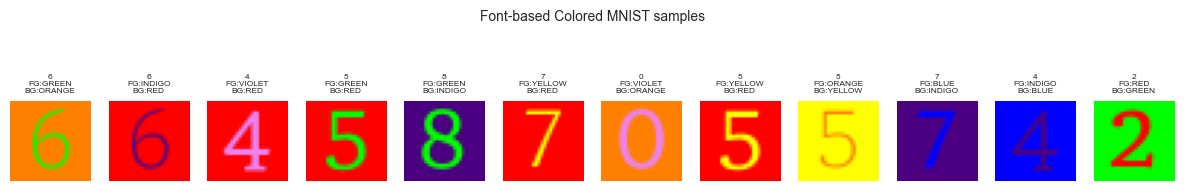

In [14]:
# ------------------------------------------------------------
# [Cell 13] EDA-3: Font-based Samples Preview (if exists)
# ------------------------------------------------------------
def show_font_samples(X_font, y_digit_font, y_fg_font, y_bg_font, n=12):
    """Visualize some font-based colored samples."""
    n = min(n, len(X_font))
    idxs = np.random.choice(len(X_font), n, replace=False)
    plt.figure(figsize=(n, 2.4))
    for i, idx in enumerate(idxs):
        img = X_font[idx]
        d = int(y_digit_font[idx])
        fg = IDX2NAME[int(y_fg_font[idx])]
        bg = IDX2NAME[int(y_bg_font[idx])]
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{d}\nFG:{fg}\nBG:{bg}", fontsize=6)
    plt.suptitle("Font-based Colored MNIST samples", fontsize=10)
    plt.tight_layout()
    plt.show()

if isinstance(X_font, np.ndarray) and X_font.size > 0:
    show_font_samples(X_font, y_font_digit, y_font_fg, y_font_bg)

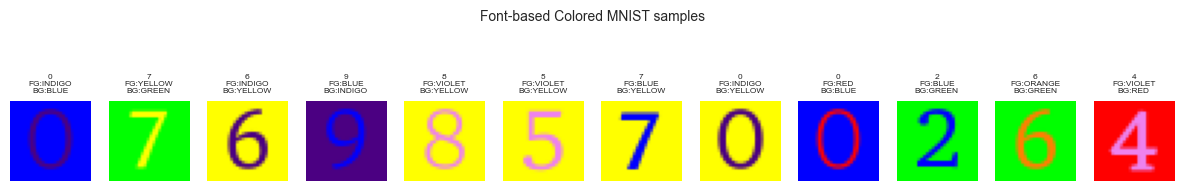

In [15]:
# ------------------------------------------------------------
# [Cell 13] EDA-3: Font-based Samples Preview (if exists)
# ------------------------------------------------------------
def show_font_samples(X_font, y_digit_font, y_fg_font, y_bg_font, n=12):
    """Visualize some font-based colored samples."""
    n = min(n, len(X_font))
    idxs = np.random.choice(len(X_font), n, replace=False)
    plt.figure(figsize=(n, 2.4))
    for i, idx in enumerate(idxs):
        img = X_font[idx]
        d = int(y_digit_font[idx])
        fg = IDX2NAME[int(y_fg_font[idx])]
        bg = IDX2NAME[int(y_bg_font[idx])]
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{d}\nFG:{fg}\nBG:{bg}", fontsize=6)
    plt.suptitle("Font-based Colored MNIST samples", fontsize=10)
    plt.tight_layout()
    plt.show()

if isinstance(X_font, np.ndarray) and X_font.size > 0:
    show_font_samples(X_font, y_font_digit, y_font_fg, y_font_bg)

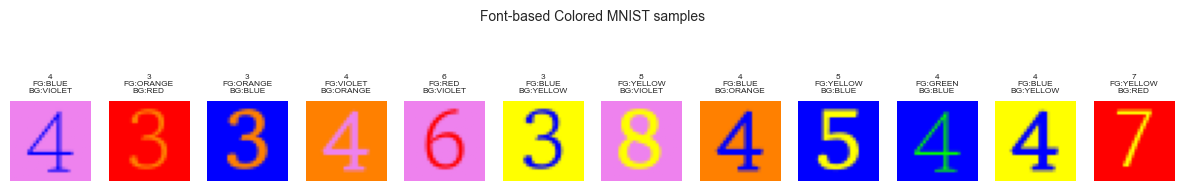

In [16]:
# ------------------------------------------------------------
# [Cell 13] EDA-3: Font-based Samples Preview (if exists)
# ------------------------------------------------------------
def show_font_samples(X_font, y_digit_font, y_fg_font, y_bg_font, n=12):
    """Visualize some font-based colored samples."""
    n = min(n, len(X_font))
    idxs = np.random.choice(len(X_font), n, replace=False)
    plt.figure(figsize=(n, 2.4))
    for i, idx in enumerate(idxs):
        img = X_font[idx]
        d = int(y_digit_font[idx])
        fg = IDX2NAME[int(y_fg_font[idx])]
        bg = IDX2NAME[int(y_bg_font[idx])]
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{d}\nFG:{fg}\nBG:{bg}", fontsize=6)
    plt.suptitle("Font-based Colored MNIST samples", fontsize=10)
    plt.tight_layout()
    plt.show()

if isinstance(X_font, np.ndarray) and X_font.size > 0:
    show_font_samples(X_font, y_font_digit, y_font_fg, y_font_bg)

In [17]:
# ------------------------------------------------------------
# [Cell 14] Merge Base + Font with Source Flag
#   - y_source_all: 0 = base, 1 = font
# ------------------------------------------------------------
if isinstance(X_font, np.ndarray) and X_font.size > 0:
    use_font = True
    N_font = X_font.shape[0]

    X_all = np.concatenate([X_base, X_font], axis=0)
    y_digit_all = np.concatenate([y_base_digit, y_font_digit], axis=0)
    y_fg_all = np.concatenate([y_base_fg, y_font_fg], axis=0)
    y_bg_all = np.concatenate([y_base_bg, y_font_bg], axis=0)
    y_source_all = np.concatenate(
        [np.zeros(N_base, dtype=np.int64),
         np.ones(N_font, dtype=np.int64)],
        axis=0
    )

    print(f"[OK] Merged base + font: base={N_base}, font={N_font}, total={X_all.shape[0]}")
else:
    use_font = False
    X_all = X_base
    y_digit_all = y_base_digit
    y_fg_all = y_base_fg
    y_bg_all = y_base_bg
    y_source_all = np.zeros(N_base, dtype=np.int64)

    print(f"[OK] Using base only: total={X_all.shape[0]}")

assert X_all.shape[0] == y_digit_all.shape[0] == y_fg_all.shape[0] == y_bg_all.shape[0] == y_source_all.shape[0], \
    "[ERROR] Mismatch in merged dataset lengths."

N_total = X_all.shape[0]
print("[OK] Final merged dataset shape:", X_all.shape)

[OK] Merged base + font: base=60000, font=4000, total=64000
[OK] Final merged dataset shape: (64000, 28, 28, 3)


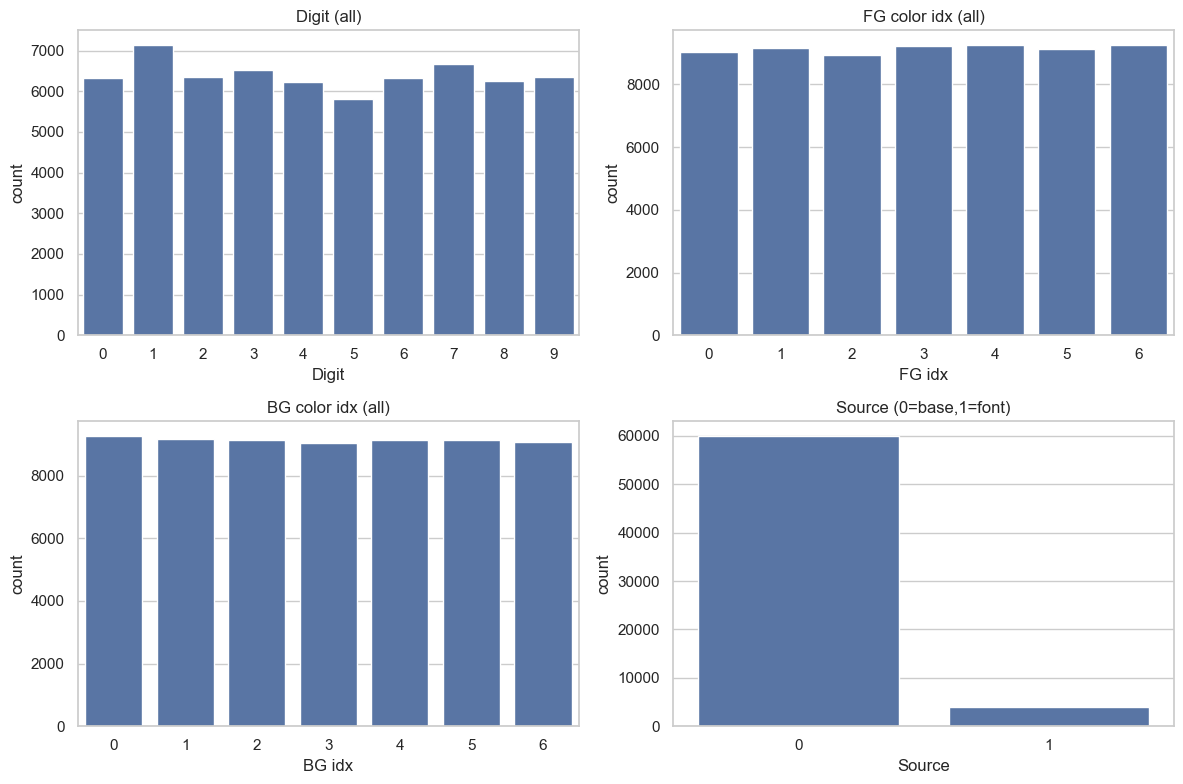

In [18]:
# ------------------------------------------------------------
# [Cell 15] EDA-4: Global Distributions (after merge)
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.countplot(x=y_digit_all, ax=axes[0,0])
axes[0,0].set_title("Digit (all)")
axes[0,0].set_xlabel("Digit")

sns.countplot(x=y_fg_all, ax=axes[0,1])
axes[0,1].set_title("FG color idx (all)")
axes[0,1].set_xlabel("FG idx")

sns.countplot(x=y_bg_all, ax=axes[1,0])
axes[1,0].set_title("BG color idx (all)")
axes[1,0].set_xlabel("BG idx")

sns.countplot(x=y_source_all, ax=axes[1,1])
axes[1,1].set_title("Source (0=base,1=font)")
axes[1,1].set_xlabel("Source")

plt.tight_layout()
plt.show()

In [19]:
# ------------------------------------------------------------
# [Cell 16] Flatten & Scale Features
#   - X_all_raw : (N, 28*28*3), values in [0,1]
#   - X_all_scaled : StandardScaler (0 mean, unit variance)
# ------------------------------------------------------------
X_all_raw = X_all.reshape(N_total, -1).astype(np.float32)

scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all_raw).astype(np.float32)

print("[OK] Features ready:")
print("  X_all_raw    :", X_all_raw.shape)
print("  X_all_scaled :", X_all_scaled.shape)

[OK] Features ready:
  X_all_raw    : (64000, 2352)
  X_all_scaled : (64000, 2352)


In [20]:
# ------------------------------------------------------------
# [Cell 17] Train / Val / Test Split (8:1:1)
#   - Stratified by digit labels
# ------------------------------------------------------------
TEST_RATIO = 0.1  # 10% test
VAL_RATIO = 0.1   # 10% val

idx_all = np.arange(N_total)

# Step 1: extract test set
idx_train_val, idx_test = train_test_split(
    idx_all,
    test_size=TEST_RATIO,
    random_state=SEED,
    stratify=y_digit_all
)

# Step 2: split train vs val within train_val
remaining_ratio = 1.0 - TEST_RATIO
val_ratio_within = VAL_RATIO / remaining_ratio

idx_train, idx_val = train_test_split(
    idx_train_val,
    test_size=val_ratio_within,
    random_state=SEED,
    stratify=y_digit_all[idx_train_val]
)

def pick(a, idx):
    """Index helper for cleaner code."""
    return a[idx]

# scaled features
X_train = pick(X_all_scaled, idx_train)
X_val   = pick(X_all_scaled, idx_val)
X_test  = pick(X_all_scaled, idx_test)

# raw features
X_train_raw = pick(X_all_raw, idx_train)
X_val_raw   = pick(X_all_raw, idx_val)
X_test_raw  = pick(X_all_raw, idx_test)

# labels
y_digit_train = pick(y_digit_all, idx_train)
y_digit_val   = pick(y_digit_all, idx_val)
y_digit_test  = pick(y_digit_all, idx_test)

y_fg_train = pick(y_fg_all, idx_train)
y_fg_val   = pick(y_fg_all, idx_val)
y_fg_test  = pick(y_fg_all, idx_test)

y_bg_train = pick(y_bg_all, idx_train)
y_bg_val   = pick(y_bg_all, idx_val)
y_bg_test  = pick(y_bg_all, idx_test)

y_source_train = pick(y_source_all, idx_train)
y_source_val   = pick(y_source_all, idx_val)
y_source_test  = pick(y_source_all, idx_test)

print("[INFO] Split sizes:")
print("  Train:", X_train.shape[0])
print("  Val  :", X_val.shape[0])
print("  Test :", X_test.shape[0])

[INFO] Split sizes:
  Train: 51200
  Val  : 6400
  Test : 6400


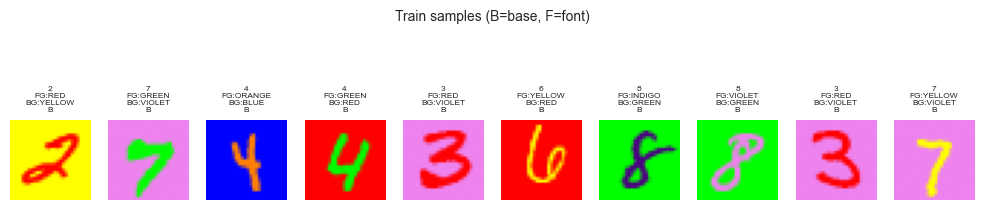

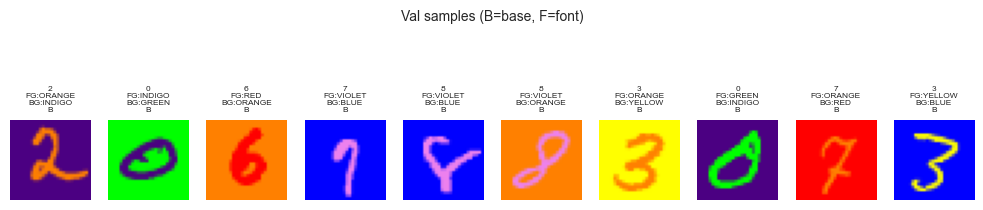

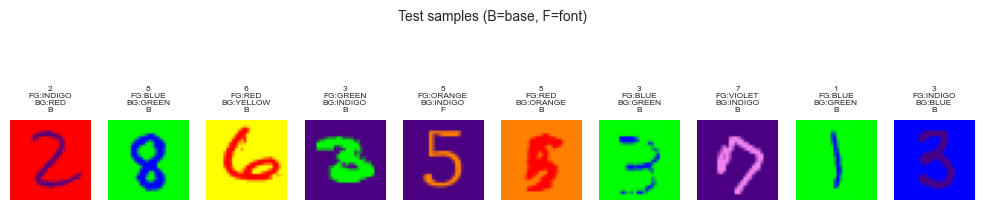

In [21]:
# ------------------------------------------------------------
# [Cell 19] EDA-6: Visual Samples per Split
# ------------------------------------------------------------
def show_split_samples(X_raw, y_digit, y_fg, y_bg, y_source, n=10, title="Samples"):
    n = min(n, len(X_raw))
    idxs = np.random.choice(len(X_raw), n, replace=False)
    plt.figure(figsize=(n, 2.8))
    for i, idx in enumerate(idxs):
        img = X_raw[idx].reshape(28, 28, 3)
        d = int(y_digit[idx])
        fg = IDX2NAME[int(y_fg[idx])]
        bg = IDX2NAME[int(y_bg[idx])]
        src = "B" if int(y_source[idx]) == 0 else "F"
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{d}\nFG:{fg}\nBG:{bg}\n{src}", fontsize=6)
    plt.suptitle(title, fontsize=10)
    plt.tight_layout()
    plt.show()

show_split_samples(
    X_train_raw, y_digit_train, y_fg_train, y_bg_train, y_source_train,
    title="Train samples (B=base, F=font)"
)
show_split_samples(
    X_val_raw, y_digit_val, y_fg_val, y_bg_val, y_source_val,
    title="Val samples (B=base, F=font)"
)
show_split_samples(
    X_test_raw, y_digit_test, y_fg_test, y_bg_test, y_source_test,
    title="Test samples (B=base, F=font)"
)

In [22]:
# ------------------------------------------------------------
# [Cell 20] Save Final NPZ
#   - Single source of truth for 02_xxx notebooks
# ------------------------------------------------------------
OUT_PATH = os.path.join(OUT_DIR, "colored_mnist.npz")

np.savez_compressed(
    OUT_PATH,
    # scaled
    X_train=X_train,
    X_val=X_val,
    X_test=X_test,
    # raw
    X_train_raw=X_train_raw,
    X_val_raw=X_val_raw,
    X_test_raw=X_test_raw,
    # labels
    y_digit_train=y_digit_train,
    y_digit_val=y_digit_val,
    y_digit_test=y_digit_test,
    y_fg_train=y_fg_train,
    y_fg_val=y_fg_val,
    y_fg_test=y_fg_test,
    y_bg_train=y_bg_train,
    y_bg_val=y_bg_val,
    y_bg_test=y_bg_test,
    # source flags
    y_source_train=y_source_train,
    y_source_val=y_source_val,
    y_source_test=y_source_test,
)

print(f"[OK] Saved final dataset → {OUT_PATH}")
print("[DONE] 01_preprocessing_colored_mnist completed.")

[OK] Saved final dataset → c:\src\colored-mnist-classification\data\processed\colored_mnist\colored_mnist.npz
[DONE] 01_preprocessing_colored_mnist completed.
